# Домашка 

## Задание 1 (8 баллов)

Обучите модель с минимум 15 слоями, где у каждого слоя разные параметры (Dropout, Conv1d и Pooling, Linear считаются слоями, остальное нет, но их тоже можно использовать). Как минимум 4 слоя должны быть наложены друг на друга и как минимум 2 параллельных слоя (последовательности слоев). Должен быть хотя бы один слой каждого типа.

Вместо графиков f1 меры сделайте графики для точности и полноты. Пообучайте модель подольше, чтобы посмотреть на то как изменяются метрики. 

Напишите короткую функцию для предсказания класса отдельного текста. Возьмите любой новый новостной текст и предскажите его класс. Правильное ли предсказание?

Советы: Начните с небольших сетей и постепенно добавляйте слои и увеличивайте параметры, не пытайтесь сразу собрать все слои. Иногда кернел может крашиться просто так или из-за слишком больших матриц. Помимо уменьшения параметров, вы можете попробовать уменьшить batch size.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from collections import Counter
from tqdm.notebook import tqdm
import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem


nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/futyn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### 1. Загружаем данные и смотрим на баланс классов

In [2]:
url = "https://github.com/mannefedov/compling_nlp_hse_course/raw/master/data/lenta_40k.csv.zip"
data = pd.read_csv(url)

data.dropna(subset=['topic', 'text'], inplace=True)

data.head()

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия


In [3]:
print(data['topic'].value_counts())

topic
Россия               9622
Мир                  8193
Экономика            4768
Спорт                3894
Наука и техника      3204
Культура             3183
Бывший СССР          3182
Интернет и СМИ       2643
Из жизни             1679
Дом                  1315
Силовые структуры    1203
Ценности              460
Бизнес                433
Путешествия           418
69-я параллель         82
Крым                   43
Культпросвет           25
Легпром                 6
Библиотека              3
Name: count, dtype: int64


In [4]:
# Выбрасываем два последних класса, примеров очень мало
data = data[~data['topic'].isin(['Легпром', 'Библиотека'])]

### 2. Препроцессинг

Я решил немного улучшить препроцессинг из семинара, добавив лемматизацию и удаление стоп-слов. Учитывая, что мы тренируем модель с нуля, а не работаем с каким-либо претрейном, это должно улучшить метрики хотя бы потому что при таком же размере словаря мы покроем больше лексем.

In [5]:
mystem = Mystem()
russian_stopwords = set(stopwords.words("russian"))


def preprocess_text(text):
    lemmas = mystem.lemmatize(text)
    tokens = [token for token in lemmas if token.isalnum()
              and token not in russian_stopwords]
    return tokens

In [6]:
# Препроцессим сразу весь датасет один раз
tqdm.pandas(desc="Preprocessing text")
data['processed_tokens'] = data['text'].progress_apply(preprocess_text)

Preprocessing text:   0%|          | 0/44347 [00:00<?, ?it/s]

### 3. Собираем словарь, делим данные на выборки и готовим датасет

Уменьшим частотный порог в два раза, так как наш словарь за счёт лемматизации существенно меньше

In [7]:
vocab = Counter()
for tokens in data['processed_tokens']:
    vocab.update(tokens)

filtered_vocab = {word for word, count in vocab.items() if count > 15}

In [8]:
print(f"Размер словаря без фильтрации: {len(vocab)}")
print(f"Размер отфильтрованного словаря: {len(filtered_vocab)}")

Размер словаря без фильтрации: 140210
Размер отфильтрованного словаря: 20441


In [9]:
# Индексируем
word2id = {'PAD': 0}
for word in filtered_vocab:
    word2id[word] = len(word2id)

# Кодируем лейблы
id2label = {i: l for i, l in enumerate(set(data.topic))}
label2id = {l: i for i, l in id2label.items()}

# Готовим данные для torch_dataset
texts_tokens = data['processed_tokens'].values
targets = [label2id[l] for l in data.topic]

In [10]:
# Делим на выборки
train_tokens, valid_tokens, train_targets, valid_targets = train_test_split(
    texts_tokens, targets, test_size=0.05, stratify=targets, random_state=42
)

In [11]:
# Датасет
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, word2id, max_len, tokens_list, targets):
        self.texts = [torch.LongTensor(
            [word2id[w] for w in t if w in word2id][:max_len]) for t in tokens_list]
        self.texts = torch.nn.utils.rnn.pad_sequence(
            self.texts, batch_first=True, padding_value=0)
        self.target = torch.LongTensor(targets)
        self.length = len(tokens_list)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        return self.texts[index], self.target[index]

In [12]:
MAX_LEN = 200
BATCH_SIZE = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = TextDataset(word2id, MAX_LEN, train_tokens, train_targets)
valid_dataset = TextDataset(word2id, MAX_LEN, valid_tokens, valid_targets)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

### 4. Сложная свёрточная нейронка

У нас будет три параллельных набора слоёв, которые будут отличаться, главным образом, параметром kernel_size — для обработки последовательностей разной длины. Первый будет обрабатывать триграммы, второй — 5-граммы (с паддингом), а третий — биграммы (с паддингом и адаптивным пуллингом). Четвёртый набор слоёв — это классификатор, который соберёт все эти фичи и выдаст результат — в нём будет несколько линейных слоёв. Везде будем использовать дропаут и batch_norm.

In [24]:
class ComplexCNN(nn.Module):
    def __init__(self, vocab_size, emb_dim, num_classes):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, emb_dim)

        # Первая ветка (Kernel Size 3 - обрабатываем триграммы)
        self.conv1_1 = nn.Conv1d(
            emb_dim,
            64,
            kernel_size=3,
            padding=1)  # Первый слой - свёрточный
        self.bn1_1 = nn.BatchNorm1d(64)  # Батчнорм
        self.drop1_1 = nn.Dropout(0.3)  # Второй слой - дропаут

        self.conv1_2 = nn.Conv1d(
            64,
            128,
            kernel_size=3,
            padding=1)  # Третий слой - свёрточный (stacked)
        self.bn1_2 = nn.BatchNorm1d(128)
        # Четвёртый слой - макспуллинг
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        # Ветка 2 (Kernel Size 5 - обрабатываем 5-граммы)
        # Слой 5 - свёрточный, параллельный слою 1, с паддингом, чтобы потом
        # объединить
        self.conv2_1 = nn.Conv1d(emb_dim, 64, kernel_size=5, padding=2)
        self.bn2_1 = nn.BatchNorm1d(64)
        self.drop2_1 = nn.Dropout(0.3)

        self.conv2_2 = nn.Conv1d(
            64,
            128,
            kernel_size=5,
            padding=2)  # Седьмой слой параллельный слою 3
        self.bn2_2 = nn.BatchNorm1d(128)
        # Восьмой слой пуллинга параллельный слою 4
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        # Ветка 3 (Kernel Size 2 - обрабатываем биграммы)
        self.conv3_1 = nn.Conv1d(
            emb_dim,
            64,
            kernel_size=2,
            padding=1)  # Девятый слой параллельный слоям 1 и 5
        self.drop3_1 = nn.Dropout(0.3)
        self.pool3 = nn.AdaptiveMaxPool1d(
            MAX_LEN // 2)  # Слой 11 - адаптивный пуллинг

        # Классификатор
        # Вычисляем размер входа
        self.flatten_dim = 320 * (MAX_LEN // 2)

        self.fc1 = nn.Linear(self.flatten_dim, 256)  # Слой 12 - линейный
        # 13 слой - регуляризуем дропаутом побольше
        self.drop_fc1 = nn.Dropout(0.4)

        self.fc2 = nn.Linear(256, 128)  # Слой 14 - линейный
        self.fc3 = nn.Linear(128, num_classes)  # Слой 15 - выходной

    def forward(self, text):
        embedded = self.embedding(text).permute(0, 2, 1)

        # Первая ветка
        x1 = F.relu(self.bn1_1(self.conv1_1(embedded)))
        x1 = self.drop1_1(x1)
        x1 = F.relu(self.bn1_2(self.conv1_2(x1)))
        x1 = self.pool1(x1)

        # Вторая ветка
        x2 = F.relu(self.bn2_1(self.conv2_1(embedded)))
        x2 = self.drop2_1(x2)
        x2 = F.relu(self.bn2_2(self.conv2_2(x2)))
        x2 = self.pool2(x2)

        # Третья ветка
        x3 = F.relu(self.conv3_1(embedded))
        x3 = self.drop3_1(x3)
        x3 = self.pool3(x3)

        # Объединяем фичи
        if x3.size(2) != x1.size(2):
            x3 = F.pad(x3, (0, x1.size(2) - x3.size(2)))

        combined = torch.cat([x1, x2, x3], dim=1)

        # Плющим и классифицируем
        flat = torch.flatten(combined, 1)
        out = F.relu(self.fc1(flat))
        out = self.drop_fc1(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)

        return out

In [25]:
model = ComplexCNN(len(word2id), 100, len(label2id))
model.to(device)
optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-5)
criterion = nn.CrossEntropyLoss().to(device)

### 5. Цикл обучения

In [13]:
def train_epoch(model, iterator, optimizer, criterion):
    model.train()
    metrics = {
        'loss': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'accuracy': []}

    for texts, ys in tqdm(iterator, desc="Training", leave=False):
        texts, ys = texts.to(device), ys.to(device)
        optimizer.zero_grad()

        predictions = model(texts)
        loss = criterion(predictions, ys)
        loss.backward()
        optimizer.step()

        preds = predictions.argmax(1).cpu().numpy()
        y_true = ys.cpu().numpy()

        metrics['loss'].append(loss.item())
        metrics['precision'].append(
            precision_score(
                y_true,
                preds,
                average='macro',
                zero_division=0))
        metrics['recall'].append(
            recall_score(
                y_true,
                preds,
                average='macro',
                zero_division=0))
        metrics['f1'].append(
            f1_score(
                y_true,
                preds,
                average='macro',
                zero_division=0))
        metrics['accuracy'].append(accuracy_score(y_true, preds))

    return {k: np.mean(v) for k, v in metrics.items()}


def evaluate(model, iterator, criterion, print_report=False):
    model.eval()
    metrics = {
        'loss': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'accuracy': []}
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for texts, ys in iterator:
            texts, ys = texts.to(device), ys.to(device)
            predictions = model(texts)
            loss = criterion(predictions, ys)

            preds = predictions.argmax(1).cpu().numpy()
            y_true = ys.cpu().numpy()

            all_preds.extend(preds)
            all_targets.extend(y_true)

            metrics['loss'].append(loss.item())
            metrics['precision'].append(
                precision_score(
                    y_true,
                    preds,
                    average='macro',
                    zero_division=0))
            metrics['recall'].append(
                recall_score(
                    y_true,
                    preds,
                    average='macro',
                    zero_division=0))
            metrics['f1'].append(
                f1_score(
                    y_true,
                    preds,
                    average='macro',
                    zero_division=0))
            metrics['accuracy'].append(accuracy_score(y_true, preds))

    if print_report:
        print("\nClassification Report (Validation):")
        print(
            classification_report(
                all_targets,
                all_preds,
                target_names=[
                    id2label[i] for i in range(
                        len(id2label))]))

    return {k: np.mean(v) for k, v in metrics.items()}

### 6. Обучаем и оцениваем

In [27]:
num_epochs = 30
history = {
    'train_precision': [],
    'train_recall': [],
    'val_precision': [],
    'val_recall': []}

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    train_metrics = train_epoch(model, train_loader, optimizer, criterion)

    val_metrics = evaluate(model, valid_loader, criterion, print_report=False)

    print(
        f"Train - Precision: {train_metrics['precision']:.3f}, Recall: {train_metrics['recall']:.3f}, F1: {train_metrics['f1']:.3f}, Accuracy: {train_metrics['accuracy']:.3f}")
    print(
        f"Valid - Precision: {val_metrics['precision']:.3f}, Recall: {val_metrics['recall']:.3f}, F1: {val_metrics['f1']:.3f}, Accuracy: {val_metrics['accuracy']:.3f}")

    history['train_precision'].append(train_metrics['precision'])
    history['train_recall'].append(train_metrics['recall'])
    history['val_precision'].append(val_metrics['precision'])
    history['val_recall'].append(val_metrics['recall'])

Epoch 1/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.074, Recall: 0.114, F1: 0.077, Accuracy: 0.247
Valid - Precision: 0.161, Recall: 0.222, F1: 0.173, Accuracy: 0.362
Epoch 2/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.188, Recall: 0.236, F1: 0.195, Accuracy: 0.406
Valid - Precision: 0.256, Recall: 0.325, F1: 0.279, Accuracy: 0.522
Epoch 3/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.259, Recall: 0.315, F1: 0.271, Accuracy: 0.535
Valid - Precision: 0.284, Recall: 0.349, F1: 0.302, Accuracy: 0.569
Epoch 4/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.333, Recall: 0.369, F1: 0.330, Accuracy: 0.596
Valid - Precision: 0.403, Recall: 0.407, F1: 0.378, Accuracy: 0.639
Epoch 5/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.375, Recall: 0.411, F1: 0.375, Accuracy: 0.638
Valid - Precision: 0.418, Recall: 0.435, F1: 0.409, Accuracy: 0.666
Epoch 6/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.404, Recall: 0.437, F1: 0.404, Accuracy: 0.665
Valid - Precision: 0.425, Recall: 0.445, F1: 0.424, Accuracy: 0.672
Epoch 7/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.442, Recall: 0.467, F1: 0.439, Accuracy: 0.691
Valid - Precision: 0.465, Recall: 0.468, F1: 0.453, Accuracy: 0.679
Epoch 8/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.467, Recall: 0.489, F1: 0.463, Accuracy: 0.707
Valid - Precision: 0.469, Recall: 0.478, F1: 0.461, Accuracy: 0.689
Epoch 9/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.499, Recall: 0.513, F1: 0.491, Accuracy: 0.725
Valid - Precision: 0.488, Recall: 0.497, F1: 0.479, Accuracy: 0.693
Epoch 10/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.514, Recall: 0.530, F1: 0.508, Accuracy: 0.741
Valid - Precision: 0.530, Recall: 0.506, F1: 0.496, Accuracy: 0.697
Epoch 11/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.547, Recall: 0.557, F1: 0.537, Accuracy: 0.755
Valid - Precision: 0.506, Recall: 0.510, F1: 0.494, Accuracy: 0.695
Epoch 12/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.568, Recall: 0.573, F1: 0.555, Accuracy: 0.770
Valid - Precision: 0.512, Recall: 0.536, F1: 0.511, Accuracy: 0.695
Epoch 13/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.591, Recall: 0.596, F1: 0.578, Accuracy: 0.783
Valid - Precision: 0.533, Recall: 0.533, F1: 0.520, Accuracy: 0.696
Epoch 14/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.606, Recall: 0.606, F1: 0.589, Accuracy: 0.792
Valid - Precision: 0.540, Recall: 0.519, F1: 0.507, Accuracy: 0.672
Epoch 15/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.630, Recall: 0.629, F1: 0.612, Accuracy: 0.803
Valid - Precision: 0.553, Recall: 0.526, F1: 0.521, Accuracy: 0.689
Epoch 16/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.642, Recall: 0.642, F1: 0.627, Accuracy: 0.812
Valid - Precision: 0.548, Recall: 0.551, F1: 0.533, Accuracy: 0.701
Epoch 17/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.663, Recall: 0.665, F1: 0.649, Accuracy: 0.822
Valid - Precision: 0.555, Recall: 0.545, F1: 0.534, Accuracy: 0.704
Epoch 18/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.679, Recall: 0.675, F1: 0.661, Accuracy: 0.832
Valid - Precision: 0.544, Recall: 0.548, F1: 0.527, Accuracy: 0.692
Epoch 19/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.694, Recall: 0.693, F1: 0.678, Accuracy: 0.842
Valid - Precision: 0.538, Recall: 0.530, F1: 0.518, Accuracy: 0.697
Epoch 20/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.697, Recall: 0.696, F1: 0.681, Accuracy: 0.846
Valid - Precision: 0.538, Recall: 0.530, F1: 0.517, Accuracy: 0.699
Epoch 21/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.708, Recall: 0.709, F1: 0.694, Accuracy: 0.851
Valid - Precision: 0.538, Recall: 0.553, F1: 0.529, Accuracy: 0.696
Epoch 22/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.719, Recall: 0.719, F1: 0.704, Accuracy: 0.859
Valid - Precision: 0.541, Recall: 0.564, F1: 0.531, Accuracy: 0.691
Epoch 23/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.740, Recall: 0.740, F1: 0.726, Accuracy: 0.867
Valid - Precision: 0.546, Recall: 0.553, F1: 0.529, Accuracy: 0.688
Epoch 24/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.731, Recall: 0.732, F1: 0.718, Accuracy: 0.869
Valid - Precision: 0.542, Recall: 0.546, F1: 0.523, Accuracy: 0.687
Epoch 25/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.742, Recall: 0.741, F1: 0.727, Accuracy: 0.871
Valid - Precision: 0.549, Recall: 0.564, F1: 0.536, Accuracy: 0.697
Epoch 26/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.760, Recall: 0.760, F1: 0.746, Accuracy: 0.881
Valid - Precision: 0.535, Recall: 0.550, F1: 0.521, Accuracy: 0.676
Epoch 27/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.762, Recall: 0.761, F1: 0.747, Accuracy: 0.880
Valid - Precision: 0.562, Recall: 0.565, F1: 0.536, Accuracy: 0.687
Epoch 28/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.763, Recall: 0.761, F1: 0.748, Accuracy: 0.885
Valid - Precision: 0.556, Recall: 0.549, F1: 0.534, Accuracy: 0.691
Epoch 29/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.778, Recall: 0.776, F1: 0.763, Accuracy: 0.888
Valid - Precision: 0.553, Recall: 0.556, F1: 0.531, Accuracy: 0.685
Epoch 30/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.782, Recall: 0.781, F1: 0.769, Accuracy: 0.894
Valid - Precision: 0.552, Recall: 0.553, F1: 0.530, Accuracy: 0.693


In [28]:
# Оцениваем финальную модель
evaluate(model, valid_loader, criterion, print_report=True)


Classification Report (Validation):
                   precision    recall  f1-score   support

      Путешествия       0.17      0.43      0.24        21
  Наука и техника       0.76      0.77      0.77       160
        Экономика       0.81      0.76      0.78       239
Силовые структуры       0.23      0.20      0.21        60
      Бывший СССР       0.81      0.68      0.74       159
            Спорт       0.94      0.96      0.95       195
         Культура       0.86      0.67      0.76       159
   Интернет и СМИ       0.41      0.77      0.53       132
           Россия       0.75      0.71      0.73       481
           Бизнес       0.43      0.14      0.21        22
             Крым       0.00      0.00      0.00         2
              Дом       0.68      0.65      0.67        66
         Из жизни       0.31      0.27      0.29        84
    Культпросвет        0.00      0.00      0.00         1
   69-я параллель       0.00      0.00      0.00         4
         Ценности 

/home/futyn/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/futyn/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/futyn/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'loss': np.float64(1.1213682459460363),
 'precision': np.float64(0.5515367530869111),
 'recall': np.float64(0.5531618550147668),
 'f1': np.float64(0.5296042469941454),
 'accuracy': np.float64(0.693307705026455)}

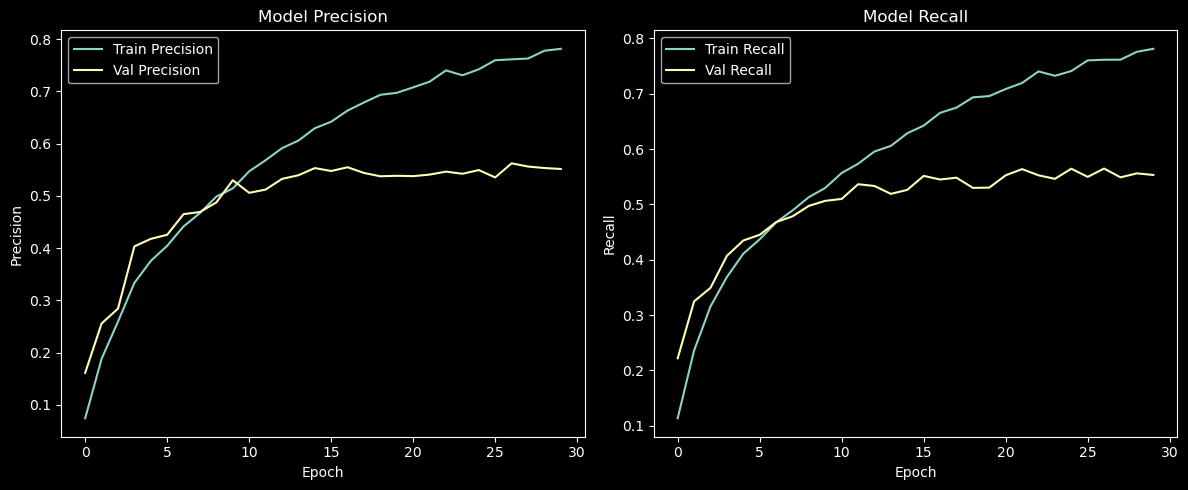

In [29]:
# Визуализируем динамику обучения
plt.figure(figsize=(12, 5))

# Precision
plt.subplot(1, 2, 1)
plt.plot(history['train_precision'], label='Train Precision')
plt.plot(history['val_precision'], label='Val Precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(1, 2, 2)
plt.plot(history['train_recall'], label='Train Recall')
plt.plot(history['val_recall'], label='Val Recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

По логам и графикам видно, что примерно до 12 эпохи у нас всё хорошо, а потом постепенно начинается переобучение: метрики на валидации выходят на плато и до 30 эпохи остаются в районе 53-55, тогда как для трейна метрики всё это время растут и к концу обучения разница составляет более 20%. Метрики precision и recall ведут себя в целом одинаково, то есть вероятностный порог предсказаний по умолчанию оптимален.

Анализ метрик для каждого класса отдельно показывает, что модель не справляется с дисбалансом классов и плохо предсказывает классы там, где примеров немного. В прочем, интересно, что лучше всего выучилась тема «Спорт», в которой меньше примеров, чем в теме «Россия» — видимо, из-за семантической неоднозначности последней.

В целом, общий результат не утешительный. В семинаре получалось лучше даже для простой полносвязной модели. Но там же уже и было видно, что усложнение свёрточной сети ухудшало метрики — видимо, на дисбаланс классов это влияет плохо, и регуляризация уже не спасает. Так что большую модель мы, конечно, сделали, но для данного датасета ничего хорошего это не дало.

### 7. Предсказание нового текста

In [14]:
def predict_text(text, model, word2id, max_len):
    tokens = preprocess_text(text)
    indices = [word2id.get(token, 0) for token in tokens][:max_len]
    if len(indices) < max_len:
        indices += [0] * (max_len - len(indices))

    tensor = torch.LongTensor([indices]).to(device)

    model.eval()
    with torch.no_grad():
        logits = model(tensor)
        predicted_class_id = logits.argmax(1).item()

    return id2label[predicted_class_id]

Я открыл Ленту и взял [вот эту статью](https://lenta.ru/news/2026/01/14/windows-flaws/) из раздела «Наука и техника».

In [35]:
text = """
Корпорация Microsoft исправила в операционной системе (ОС) Windows 114 уязвимостей. На это обратило внимание издание The Hacker News.
Журналисты заметили, что 13 января компания представила первую подборку патчей для операционных систем Windows. Авторы объяснили, что такие обновления выходят в так называемый «вторник патчей» — второй вторник каждого месяца. Специалисты Microsoft заявили, что нашли и исправили больше ста уязвимостей.
Среди 114 системных брешей 8 являются критическими, 106 оцениваются как важные. Разработчики Windows рассказали, что 58 уязвимостей связаны с повышением привилегий, 22 — помогают раскрывать конфиденциальную информацию, 21 — удаленно выполнять код, 5 — рассекречивать пароли.
Обычно Microsoft не уточняет количество активно эксплуатируемых хакерами уязвимостей. Однако в этот раз в компании признали, что системную брешь CVE-2026-20805 использовали злоумышленники. В компании заметили, что уязвимость затрагивала диспетчер окон рабочего стола.
«Злоумышленники, уже имеющие доступ к системе, могут использовать уязвимости для преодоления сложных средств защиты, поэтому оперативное обновление программного обеспечения крайне важно для поддержания доверия к границам безопасности Windows», — заявил в интервью изданию специалист по безопасности Майк Уолтерс.
Ранее корпорация Microsoft запретила активировать ОС Windows по телефону. В конце 2025 года компания оставила только один способ активации — онлайн."""

predicted_topic = predict_text(text, model, word2id, MAX_LEN)
print(f"Предсказанный класс: {predicted_topic}")

Предсказанный класс: Интернет и СМИ


Увы, нет. Попробуем из более распространённого и хорошо выученного класса. [Вот эта статья](https://lenta.ru/news/2026/01/15/serebro-rekordno-dorozhaet-vygodno-li-rossiyanam-v-nego-investirovat/) из раздела «Экономика».

In [36]:
text = """
Мировые цены на серебро продолжают бить один рекорд за другим. В среду, 14 января, биржевые котировки драгоценного металла впервые в истории преодолели отметку 91 доллар за тройскую унцию. На фоне нестабильной геополитической ситуации и стабильно высокого спроса это еще не предел, предупреждают эксперты. Однако бросаться вкладывать свои последние сбережения в серебро не стоит, отмечают аналитики. Как и золото, этот драгметалл представляет собой высоковолатильный актив — вслед за затяжным ростом может последовать не менее стремительное падение.
Биржевая стоимость серебра достигла исторического максимума
Котировки серебра на американской бирже Comex (подразделение Нью-Йоркской товарной биржи) продолжают бить рекорды. Во вторник, 13 декабря, цены на драгметалл преодолели отметку 88 долларов за тройскую унцию, а в среду, 14 числа, они впервые в истории пробили планку в размере 90 долларов, подскочив на пике до уровня 91,34 доллара. Столь высоких значений не фиксировалось на бирже за всю историю статистических наблюдений.
Рыночная капитализация серебра резко выросла
Стремительное увеличение биржевой стоимости повлекло за собой не менее активный рост рыночной капитализации драгоценного металла. Ближе к середине января 2026 года, согласно оценке портала CompaniesMarketCap (CMC), показатель превысил психологическую отметку в 5 триллионов долларов. Выше в рейтинге оказался только главный конкурент серебра — золото, котировки которого в последнее время также демонстрируют резкий прирост. Серебру же удалось обойти в списке таких технологических американских гигантов, как Nvidia (4,52 триллиона долларов), Alphabet (4,06 триллиона), Apple (3,86 триллиона).
Затяжному росту цен на серебро способствовало ограниченное предложение
Продолжительному росту биржевых котировок серебра способствовал ряд факторов. К числу основных причин подобной динамики портфельный управляющий УК «Альфа-Капитал» Дмитрий Скрябин отнес переток физического драгметалла на американские торговые площадки (в том числе на биржу Comex) и сокращение запасов в других глобальных хабах. На фоне стабильно высокого спроса это заметно ограничило глобальное предложение серебра.
Этот драгметалл, в отличие от золота, обладает куда большим функционалом, поясняют аналитики. Серебро, в частности, активно используется в самых разных сферах — от зеленой энергетики до выпуска электрокаров. Благодаря высокой электропроводности оно отлично подходит для производства солнечных панелей, аккумуляторов, микросхем и другой современной техники. Глобальный энергопереход делает еще более востребованным этот драгметалл, тогда как его предложение на мировом рынке продолжается оставаться весьма ограниченным.
$5 трлн
достигла рыночная капитализация серебра
На ценовую ситуацию также оказывает давление смягчающаяся риторика руководства Федеральной резервной системы (ФРС) США касательно дальнейших шагов по вопросу учетной ставки. Это обстоятельство, поясняет Скрябин из «Альфа-Капитала», оказывает поддержку товарным активам, включая ведущие драгметаллы вроде серебра или золота. Первый реагирует на такого рода сигналы особенно остро, так как широко используется в глобальной промышленности, констатировал аналитик.
Россиянам следует осторожно подходить к инвестициям в серебро
На фоне нестабильной геополитической ситуации в мире (захват США президента Венесуэлы Николаса Мадуро, массовые протесты в Иране, продолжающийся конфликт России и Украины и т. д.) и ослабления доллара серебро, как и золото, воспринимается участниками рынка в качестве традиционного «актива-убежища», что еще в большей степени подогревает глобальный интерес к этому драгметаллу. С учетом ограниченности мирового предложения все вышеперечисленные факторы в конечном счете будут способствовать дальнейшему удорожанию серебра, отмечают эксперты. Однако как долго продлится такая тенденция — прогнозировать крайне сложно.
Более мягкая риторика ФРС США традиционно оказывает поддержку товарным активам, включая драгметаллы
Дмитрий Скрябинпортфельный управляющий УК «Альфа-Капитал»
Серебро, как и золото, является высоковолатильным активом. При изменении рыночной конъюнктуры за затяжным удорожанием драгметалла может последовать не менее сильный спад, предупреждают эксперты. С учетом этого более разумной стратегией стал бы острожный подход к инвестициям в такого рода активы, отмечает доцент кафедры мировых финансовых рынков и финтеха РЭУ имени Г. В. Плеханова Олег Скапенкер. Приобретать драгметаллы в период биржевого ралли — весьма рискованная тактика, пояснил он. Более оптимальной тактикой, отметил аналитик, стало бы дождаться коррекции на глобальном рынке.
Для начинающих инвесторов самым простым вариантом является вложение части накоплений в обезличенные металлические счета (ОМС) в банках. Такой способ, пояснил глава департамента поддержки клиентов и продаж «Альфа-Форекс» Александр Шнейдерман, позволяет владельцам зарабатывать на росте котировок без необходимости хранить физический металл. Но стоит помнить, что подобного рода счета не охвачены системой страхования вкладов, предупредил аналитик финансового маркетплейса «Сравни» Алексей Лоссан. Альтернативой могут послужить биржевые инструменты — фонды или фьючерсы. Впрочем, эти варианты подойдут скорее опытным инвесторам. Еще одним способом заработка может стать продажа изделий из серебра в ломбарды или антикварам. Однако здесь есть риск, что конечная стоимость сделки окажется ниже рыночной. В любом случае, констатировал Лоссан, вкладывать все свои сбережения исключительно в серебро не стоит. В противном случае можно остаться ни с чем. «Периоды резкого роста могут сменяться столь же резкими коррекциями», — резюмировал эксперт."""

predicted_topic = predict_text(text, model, word2id, MAX_LEN)
print(f"Предсказанный класс: {predicted_topic}")

Предсказанный класс: Экономика


Что ж, здесь угадал.

## Задание 2 (2 балла)

Обучите нейросеть со сверточными слоями с архитектурой похожей на Unet - https://en.wikipedia.org/wiki/U-Net 
Вы можете работать как с текстами так и с картинками.

Не нужно воспроизводить все в точности, главное, чтобы было сокращение длины последовательности (или height, weight в картинках) с помощью CNN, а затем обратное увеличение до изначальной с residual связями между промежуточными шагами с одинаковыми размерностями. 
Изменений размерности должно быть хотя бы 3 и соответственно residual связей тоже. 

Для повышения размерности используйте https://docs.pytorch.org/docs/stable/generated/torch.nn.Upsample.html
Полученная модель должна давать ненулевое качество.

### 1. Модель U-Net для классификации

In [15]:
class UNetTextClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)

        # Энкодер, который сжимает входную последовательность
        # Первый блок: 200 -> 100
        self.enc1 = nn.Sequential(
            nn.Conv1d(emb_dim, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool1d(2)

        # Второй блок: 100 -> 50
        self.enc2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool1d(2)

        # Третий блок: 50 -> 25
        self.enc3 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool1d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv1d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU()
        )

        # Декодер, который восстанавливает исходную длину последовательности
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

        self.dec3 = nn.Sequential(
            nn.Conv1d(512 + 256, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )

        self.dec2 = nn.Sequential(
            nn.Conv1d(256 + 128, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )

        self.dec1 = nn.Sequential(
            nn.Conv1d(128 + 64, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )

        # Классификатор
        # Пуллинг для восстановленной последовательности
        self.global_pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, text):
        x = self.embedding(text).permute(0, 2, 1)

        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        e3 = self.enc3(p2)
        p3 = self.pool3(e3)

        b = self.bottleneck(p3)

        u3 = self.upsample(b)
        # Без этого могут вылезать ошибки, связанные с округлением
        if u3.size(2) != e3.size(2):
            u3 = F.interpolate(u3, size=e3.size(2))
        cat3 = torch.cat([u3, e3], dim=1)
        d3 = self.dec3(cat3)

        u2 = self.upsample(d3)  # 50 -> 100
        if u2.size(2) != e2.size(2):
            u2 = F.interpolate(u2, size=e2.size(2))
        cat2 = torch.cat([u2, e2], dim=1)
        d2 = self.dec2(cat2)

        u1 = self.upsample(d2)  # 100 -> 200
        if u1.size(2) != e1.size(2):
            u1 = F.interpolate(u1, size=e1.size(2))
        cat1 = torch.cat([u1, e1], dim=1)
        d1 = self.dec1(cat1)

        out = self.global_pool(d1).squeeze(2)
        out = self.fc(out)

        return out

In [16]:
unet_model = UNetTextClassifier(len(word2id), 100, len(label2id))
unet_model.to(device)

optimizer_unet = optim.AdamW(unet_model.parameters(), lr=1e-3)
criterion_unet = nn.CrossEntropyLoss().to(device)

### 2. Обучаем и оцениваем

In [17]:
num_epochs_unet = 30
unet_history = {
    'train_precision': [],
    'train_recall': [],
    'val_precision': [],
    'val_recall': []}

for epoch in range(num_epochs_unet):
    print(f"Epoch {epoch+1}/{num_epochs_unet}")

    train_metrics = train_epoch(
        unet_model,
        train_loader,
        optimizer_unet,
        criterion_unet)
    val_metrics = evaluate(
        unet_model,
        valid_loader,
        criterion_unet,
        print_report=(
            epoch == num_epochs_unet -
            1))

    print(
        f"Train - Precision: {train_metrics['precision']:.3f}, Recall: {train_metrics['recall']:.3f}, F1: {train_metrics['f1']:.3f}, Accuracy: {train_metrics['accuracy']:.3f}")
    print(
        f"Valid - Precision: {val_metrics['precision']:.3f}, Recall: {val_metrics['recall']:.3f}, F1: {val_metrics['f1']:.3f}, Accuracy: {val_metrics['accuracy']:.3f}")

    unet_history['train_precision'].append(train_metrics['precision'])
    unet_history['train_recall'].append(train_metrics['recall'])
    unet_history['val_precision'].append(val_metrics['precision'])
    unet_history['val_recall'].append(val_metrics['recall'])

Epoch 1/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.280, Recall: 0.305, F1: 0.273, Accuracy: 0.505
Valid - Precision: 0.423, Recall: 0.395, F1: 0.375, Accuracy: 0.558
Epoch 2/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.512, Recall: 0.507, F1: 0.491, Accuracy: 0.691
Valid - Precision: 0.539, Recall: 0.551, F1: 0.526, Accuracy: 0.690
Epoch 3/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.616, Recall: 0.604, F1: 0.592, Accuracy: 0.759
Valid - Precision: 0.574, Recall: 0.548, F1: 0.542, Accuracy: 0.702
Epoch 4/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.675, Recall: 0.664, F1: 0.654, Accuracy: 0.808
Valid - Precision: 0.592, Recall: 0.561, F1: 0.550, Accuracy: 0.692
Epoch 5/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.739, Recall: 0.728, F1: 0.719, Accuracy: 0.850
Valid - Precision: 0.597, Recall: 0.582, F1: 0.570, Accuracy: 0.716
Epoch 6/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.795, Recall: 0.789, F1: 0.780, Accuracy: 0.891
Valid - Precision: 0.534, Recall: 0.586, F1: 0.529, Accuracy: 0.641
Epoch 7/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.853, Recall: 0.848, F1: 0.841, Accuracy: 0.924
Valid - Precision: 0.561, Recall: 0.605, F1: 0.562, Accuracy: 0.705
Epoch 8/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.894, Recall: 0.893, F1: 0.887, Accuracy: 0.951
Valid - Precision: 0.577, Recall: 0.519, F1: 0.505, Accuracy: 0.609
Epoch 9/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.919, Recall: 0.919, F1: 0.913, Accuracy: 0.962
Valid - Precision: 0.608, Recall: 0.608, F1: 0.586, Accuracy: 0.703
Epoch 10/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.945, Recall: 0.947, F1: 0.942, Accuracy: 0.975
Valid - Precision: 0.561, Recall: 0.545, F1: 0.523, Accuracy: 0.656
Epoch 11/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.959, Recall: 0.960, F1: 0.957, Accuracy: 0.982
Valid - Precision: 0.559, Recall: 0.585, F1: 0.550, Accuracy: 0.688
Epoch 12/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.956, Recall: 0.957, F1: 0.954, Accuracy: 0.978
Valid - Precision: 0.616, Recall: 0.577, F1: 0.571, Accuracy: 0.698
Epoch 13/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.967, Recall: 0.969, F1: 0.966, Accuracy: 0.982
Valid - Precision: 0.604, Recall: 0.595, F1: 0.583, Accuracy: 0.722
Epoch 14/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.986, Recall: 0.987, F1: 0.986, Accuracy: 0.992
Valid - Precision: 0.603, Recall: 0.580, F1: 0.571, Accuracy: 0.705
Epoch 15/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.974, Recall: 0.976, F1: 0.973, Accuracy: 0.987
Valid - Precision: 0.584, Recall: 0.573, F1: 0.549, Accuracy: 0.671
Epoch 16/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.976, Recall: 0.976, F1: 0.974, Accuracy: 0.987
Valid - Precision: 0.584, Recall: 0.585, F1: 0.565, Accuracy: 0.713
Epoch 17/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.976, Recall: 0.977, F1: 0.974, Accuracy: 0.986
Valid - Precision: 0.617, Recall: 0.592, F1: 0.580, Accuracy: 0.721
Epoch 18/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.958, Recall: 0.960, F1: 0.956, Accuracy: 0.978
Valid - Precision: 0.581, Recall: 0.584, F1: 0.555, Accuracy: 0.677
Epoch 19/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.970, Recall: 0.971, F1: 0.968, Accuracy: 0.982
Valid - Precision: 0.617, Recall: 0.591, F1: 0.578, Accuracy: 0.690
Epoch 20/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.990, Recall: 0.991, F1: 0.990, Accuracy: 0.994
Valid - Precision: 0.654, Recall: 0.619, F1: 0.617, Accuracy: 0.742
Epoch 21/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.997, Recall: 0.997, F1: 0.996, Accuracy: 0.997
Valid - Precision: 0.637, Recall: 0.611, F1: 0.603, Accuracy: 0.735
Epoch 22/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.998, Recall: 0.998, F1: 0.998, Accuracy: 0.998
Valid - Precision: 0.620, Recall: 0.618, F1: 0.601, Accuracy: 0.721
Epoch 23/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.969, Recall: 0.971, F1: 0.968, Accuracy: 0.983
Valid - Precision: 0.628, Recall: 0.601, F1: 0.596, Accuracy: 0.719
Epoch 24/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.973, Recall: 0.974, F1: 0.971, Accuracy: 0.984
Valid - Precision: 0.598, Recall: 0.562, F1: 0.547, Accuracy: 0.658
Epoch 25/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.974, Recall: 0.976, F1: 0.973, Accuracy: 0.985
Valid - Precision: 0.631, Recall: 0.588, F1: 0.589, Accuracy: 0.733
Epoch 26/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.995, Recall: 0.996, F1: 0.995, Accuracy: 0.996
Valid - Precision: 0.640, Recall: 0.618, F1: 0.611, Accuracy: 0.744
Epoch 27/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.995, Recall: 0.996, F1: 0.995, Accuracy: 0.998
Valid - Precision: 0.660, Recall: 0.629, F1: 0.625, Accuracy: 0.746
Epoch 28/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.995, Recall: 0.996, F1: 0.995, Accuracy: 0.996
Valid - Precision: 0.648, Recall: 0.605, F1: 0.604, Accuracy: 0.741
Epoch 29/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Train - Precision: 0.991, Recall: 0.991, F1: 0.990, Accuracy: 0.995
Valid - Precision: 0.651, Recall: 0.599, F1: 0.596, Accuracy: 0.716
Epoch 30/30


Training:   0%|          | 0/330 [00:00<?, ?it/s]


Classification Report (Validation):
                   precision    recall  f1-score   support

              Дом       0.78      0.71      0.75        66
           Бизнес       0.27      0.18      0.22        22
         Ценности       0.81      0.74      0.77        23
   69-я параллель       0.17      0.25      0.20         4
    Культпросвет        0.00      0.00      0.00         1
           Россия       0.68      0.83      0.75       481
             Крым       0.00      0.00      0.00         2
      Бывший СССР       0.78      0.72      0.75       159
  Наука и техника       0.77      0.69      0.73       160
   Интернет и СМИ       0.66      0.61      0.63       132
Силовые структуры       0.58      0.30      0.40        60
        Экономика       0.76      0.78      0.77       239
      Путешествия       0.35      0.43      0.38        21
         Культура       0.84      0.82      0.83       159
              Мир       0.79      0.70      0.74       410
            Спорт 

/home/futyn/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/futyn/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/futyn/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


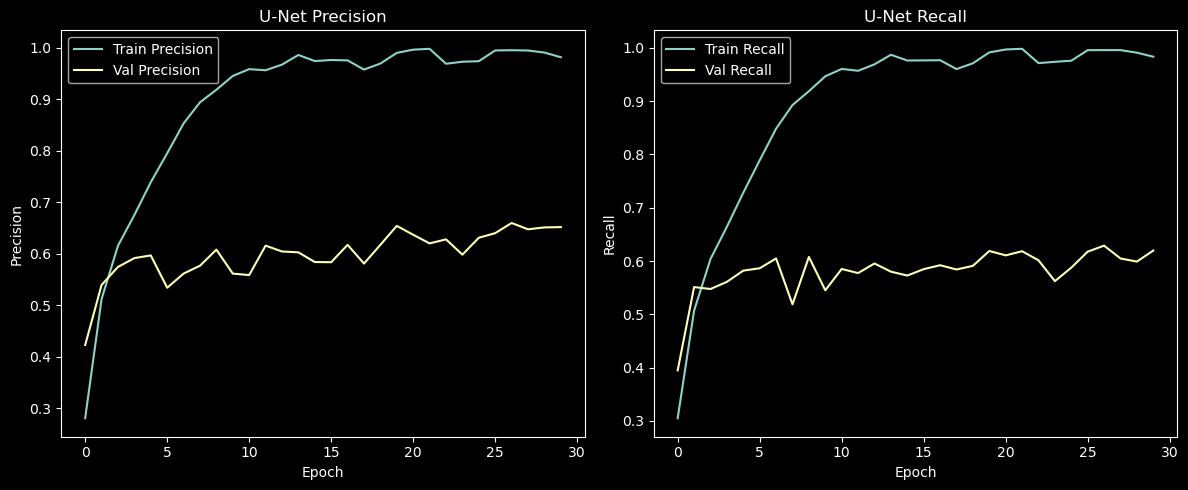

In [18]:
# Визуализируем динамику обучения
plt.figure(figsize=(12, 5))

# Precision
plt.subplot(1, 2, 1)
plt.plot(unet_history['train_precision'], label='Train Precision')
plt.plot(unet_history['val_precision'], label='Val Precision')
plt.title('U-Net Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(1, 2, 2)
plt.plot(unet_history['train_recall'], label='Train Recall')
plt.plot(unet_history['val_recall'], label='Val Recall')
plt.title('U-Net Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

Довольно интересные результаты! Во-первых, итоговое качество немного выше, чем для модели из первого задания, особенно на некоторых редких классах, типа "Силовые структуры". Во-вторых, динамика обучения показывает, что модель обучается намного быстрее модели из первого задания, и, соответственно, переобучается тоже быстрее. Оно и не удивительно, ведь у нас получилась более глубокая нейросеть с большим количеством параметров. В-третьих, обучение более хаотичное: в первом задании у нас был небольшой, но +- стабильный рост метрик, а здесь метрики на валидации то растут, то падают, ведут себя менее стабильно.

### 3. Предсказываем

In [19]:
text = """
Корпорация Microsoft исправила в операционной системе (ОС) Windows 114 уязвимостей. На это обратило внимание издание The Hacker News.
Журналисты заметили, что 13 января компания представила первую подборку патчей для операционных систем Windows. Авторы объяснили, что такие обновления выходят в так называемый «вторник патчей» — второй вторник каждого месяца. Специалисты Microsoft заявили, что нашли и исправили больше ста уязвимостей.
Среди 114 системных брешей 8 являются критическими, 106 оцениваются как важные. Разработчики Windows рассказали, что 58 уязвимостей связаны с повышением привилегий, 22 — помогают раскрывать конфиденциальную информацию, 21 — удаленно выполнять код, 5 — рассекречивать пароли.
Обычно Microsoft не уточняет количество активно эксплуатируемых хакерами уязвимостей. Однако в этот раз в компании признали, что системную брешь CVE-2026-20805 использовали злоумышленники. В компании заметили, что уязвимость затрагивала диспетчер окон рабочего стола.
«Злоумышленники, уже имеющие доступ к системе, могут использовать уязвимости для преодоления сложных средств защиты, поэтому оперативное обновление программного обеспечения крайне важно для поддержания доверия к границам безопасности Windows», — заявил в интервью изданию специалист по безопасности Майк Уолтерс.
Ранее корпорация Microsoft запретила активировать ОС Windows по телефону. В конце 2025 года компания оставила только один способ активации — онлайн."""

predicted_topic = predict_text(text, unet_model, word2id, MAX_LEN)
print(f"Предсказанный класс: {predicted_topic}")

Предсказанный класс: Интернет и СМИ


Не, тут тоже мимо. :()

In [20]:
text = """
Мировые цены на серебро продолжают бить один рекорд за другим. В среду, 14 января, биржевые котировки драгоценного металла впервые в истории преодолели отметку 91 доллар за тройскую унцию. На фоне нестабильной геополитической ситуации и стабильно высокого спроса это еще не предел, предупреждают эксперты. Однако бросаться вкладывать свои последние сбережения в серебро не стоит, отмечают аналитики. Как и золото, этот драгметалл представляет собой высоковолатильный актив — вслед за затяжным ростом может последовать не менее стремительное падение.
Биржевая стоимость серебра достигла исторического максимума
Котировки серебра на американской бирже Comex (подразделение Нью-Йоркской товарной биржи) продолжают бить рекорды. Во вторник, 13 декабря, цены на драгметалл преодолели отметку 88 долларов за тройскую унцию, а в среду, 14 числа, они впервые в истории пробили планку в размере 90 долларов, подскочив на пике до уровня 91,34 доллара. Столь высоких значений не фиксировалось на бирже за всю историю статистических наблюдений.
Рыночная капитализация серебра резко выросла
Стремительное увеличение биржевой стоимости повлекло за собой не менее активный рост рыночной капитализации драгоценного металла. Ближе к середине января 2026 года, согласно оценке портала CompaniesMarketCap (CMC), показатель превысил психологическую отметку в 5 триллионов долларов. Выше в рейтинге оказался только главный конкурент серебра — золото, котировки которого в последнее время также демонстрируют резкий прирост. Серебру же удалось обойти в списке таких технологических американских гигантов, как Nvidia (4,52 триллиона долларов), Alphabet (4,06 триллиона), Apple (3,86 триллиона).
Затяжному росту цен на серебро способствовало ограниченное предложение
Продолжительному росту биржевых котировок серебра способствовал ряд факторов. К числу основных причин подобной динамики портфельный управляющий УК «Альфа-Капитал» Дмитрий Скрябин отнес переток физического драгметалла на американские торговые площадки (в том числе на биржу Comex) и сокращение запасов в других глобальных хабах. На фоне стабильно высокого спроса это заметно ограничило глобальное предложение серебра.
Этот драгметалл, в отличие от золота, обладает куда большим функционалом, поясняют аналитики. Серебро, в частности, активно используется в самых разных сферах — от зеленой энергетики до выпуска электрокаров. Благодаря высокой электропроводности оно отлично подходит для производства солнечных панелей, аккумуляторов, микросхем и другой современной техники. Глобальный энергопереход делает еще более востребованным этот драгметалл, тогда как его предложение на мировом рынке продолжается оставаться весьма ограниченным.
$5 трлн
достигла рыночная капитализация серебра
На ценовую ситуацию также оказывает давление смягчающаяся риторика руководства Федеральной резервной системы (ФРС) США касательно дальнейших шагов по вопросу учетной ставки. Это обстоятельство, поясняет Скрябин из «Альфа-Капитала», оказывает поддержку товарным активам, включая ведущие драгметаллы вроде серебра или золота. Первый реагирует на такого рода сигналы особенно остро, так как широко используется в глобальной промышленности, констатировал аналитик.
Россиянам следует осторожно подходить к инвестициям в серебро
На фоне нестабильной геополитической ситуации в мире (захват США президента Венесуэлы Николаса Мадуро, массовые протесты в Иране, продолжающийся конфликт России и Украины и т. д.) и ослабления доллара серебро, как и золото, воспринимается участниками рынка в качестве традиционного «актива-убежища», что еще в большей степени подогревает глобальный интерес к этому драгметаллу. С учетом ограниченности мирового предложения все вышеперечисленные факторы в конечном счете будут способствовать дальнейшему удорожанию серебра, отмечают эксперты. Однако как долго продлится такая тенденция — прогнозировать крайне сложно.
Более мягкая риторика ФРС США традиционно оказывает поддержку товарным активам, включая драгметаллы
Дмитрий Скрябинпортфельный управляющий УК «Альфа-Капитал»
Серебро, как и золото, является высоковолатильным активом. При изменении рыночной конъюнктуры за затяжным удорожанием драгметалла может последовать не менее сильный спад, предупреждают эксперты. С учетом этого более разумной стратегией стал бы острожный подход к инвестициям в такого рода активы, отмечает доцент кафедры мировых финансовых рынков и финтеха РЭУ имени Г. В. Плеханова Олег Скапенкер. Приобретать драгметаллы в период биржевого ралли — весьма рискованная тактика, пояснил он. Более оптимальной тактикой, отметил аналитик, стало бы дождаться коррекции на глобальном рынке.
Для начинающих инвесторов самым простым вариантом является вложение части накоплений в обезличенные металлические счета (ОМС) в банках. Такой способ, пояснил глава департамента поддержки клиентов и продаж «Альфа-Форекс» Александр Шнейдерман, позволяет владельцам зарабатывать на росте котировок без необходимости хранить физический металл. Но стоит помнить, что подобного рода счета не охвачены системой страхования вкладов, предупредил аналитик финансового маркетплейса «Сравни» Алексей Лоссан. Альтернативой могут послужить биржевые инструменты — фонды или фьючерсы. Впрочем, эти варианты подойдут скорее опытным инвесторам. Еще одним способом заработка может стать продажа изделий из серебра в ломбарды или антикварам. Однако здесь есть риск, что конечная стоимость сделки окажется ниже рыночной. В любом случае, констатировал Лоссан, вкладывать все свои сбережения исключительно в серебро не стоит. В противном случае можно остаться ни с чем. «Периоды резкого роста могут сменяться столь же резкими коррекциями», — резюмировал эксперт."""

predicted_topic = predict_text(text, unet_model, word2id, MAX_LEN)
print(f"Предсказанный класс: {predicted_topic}")

Предсказанный класс: Экономика


Ну, уже ожидаемо!